# TFT Model Demo

This notebook demonstrates the TFT (Temporal Fusion Transformer) model with comprehensive training and evaluation.

In [1]:
# Import required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple, Dict, Any
import time

# Darts imports
from darts import TimeSeries
from darts.models import TFTModel
import pytorch_lightning as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Local imports
from geospatial_neural_adapter.data.generators import generate_time_synthetic_data
from geospatial_neural_adapter.data.preprocessing import prepare_all_with_scaling, denormalize_predictions

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")

/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/wangxc17/miniconda/envs/geospatial-neural-adapter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded spatial_utils from: /home/wangxc17/work/TFTModel-use/geospatial-neural-adapter-dev/geospatial_neural_adapter/cpp_extensions/spatial_utils.so
✅ All imports successful!


## 1. Data Generation with Meaningful Correlations

We'll use the same data generator that creates features with strong correlations to targets.

In [2]:
# Generate synthetic temporal data with meaningful correlations
print("Generating correlated temporal synthetic data...")

n_locations = 50
n_time_steps = 500
locations = np.linspace(-5, 5, n_locations)
noise_std = 0.1
eigenvalue = 2.0

cat_features, cont_features, targets = generate_time_synthetic_data(
    locs=locations,
    n_time_steps=n_time_steps,
    noise_std=noise_std,
    eigenvalue=eigenvalue,
    eta_rho=0.8,
    f_rho=0.6,
    global_mean=50.0,
    feature_noise_std=0.1,
    non_linear_strength=0.2,
    seed=42
)

print(f"Data shapes: {cont_features.shape}, {targets.shape}")
print(f"Original targets - Mean: {targets.mean():.2f}, Std: {targets.std():.2f}")
print(f"Original targets - Range: {targets.min():.2f} to {targets.max():.2f}")

Generating correlated temporal synthetic data...
Data shapes: (500, 50, 3), (500, 50)
Original targets - Mean: 50.89, Std: 1.27
Original targets - Range: 48.15 to 61.75


Feature-Target Correlations:
  Feature 0: 0.6147
  Feature 1: 0.4634
  Feature 2: 0.4439


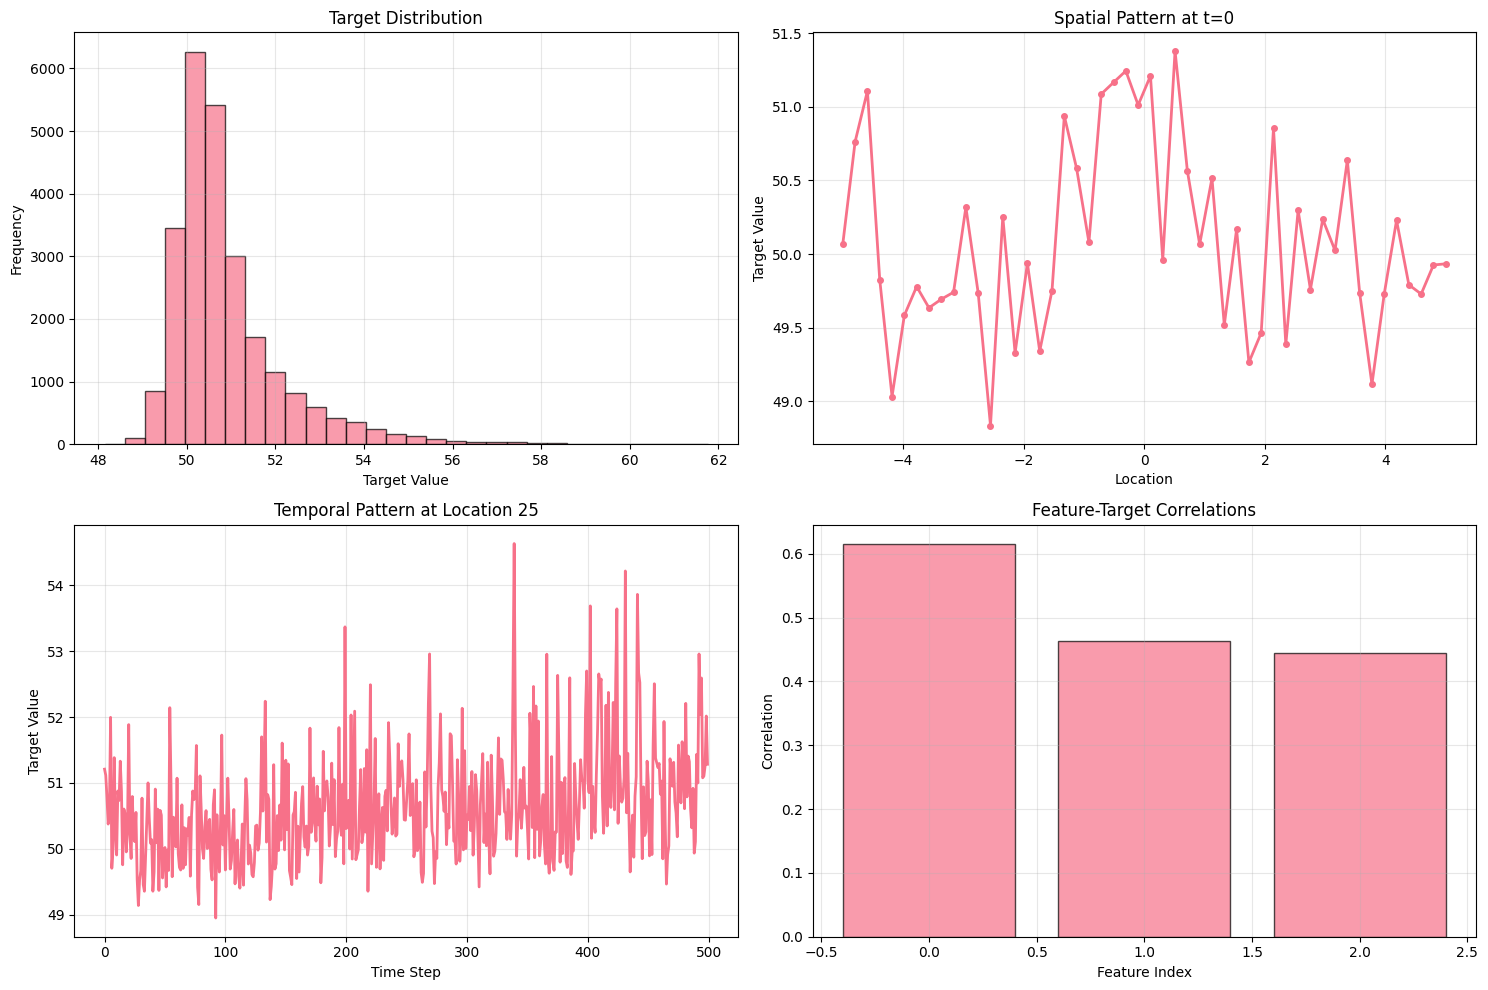

In [3]:
# Analyze feature-target correlations
print("Feature-Target Correlations:")
for i in range(cont_features.shape[-1]):
    corr = np.corrcoef(targets.flatten(), cont_features[:, :, i].flatten())[0, 1]
    print(f"  Feature {i}: {corr:.4f}")

# Visualize data characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Target distribution
axes[0, 0].hist(targets.flatten(), bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Target Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Spatial pattern at first time step
axes[0, 1].plot(locations, targets[0, :], 'o-', linewidth=2, markersize=4)
axes[0, 1].set_title('Spatial Pattern at t=0')
axes[0, 1].set_xlabel('Location')
axes[0, 1].set_ylabel('Target Value')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Temporal pattern at middle location
time_steps = np.arange(len(targets))
axes[1, 0].plot(time_steps, targets[:, 25], linewidth=2)
axes[1, 0].set_title('Temporal Pattern at Location 25')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Target Value')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature correlations
feature_corrs = []
for i in range(cont_features.shape[-1]):
    corr = np.corrcoef(targets.flatten(), cont_features[:, :, i].flatten())[0, 1]
    feature_corrs.append(corr)

axes[1, 1].bar(range(len(feature_corrs)), feature_corrs, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Feature-Target Correlations')
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Enhanced Preprocessing with Automatic Scaling

We'll use the same preprocessing pipeline that handles normalization and denormalization automatically.

In [4]:
# Prepare datasets with automatic scaling (enhanced preprocessing)
print("Preparing datasets with automatic scaling...")

# Use enhanced preprocessing with automatic scaling
train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
    cat_features=cat_features,
    cont_features=cont_features,
    targets=targets,
    train_ratio=0.8,
    val_ratio=0.15,
    feature_scaler_type="standard",
    target_scaler_type="standard",
    fit_on_train_only=True
)

train_cat, train_cont, train_targets = train_dataset.tensors
val_cat, val_cont, val_targets = val_dataset.tensors
test_cat, test_cont, test_targets = test_dataset.tensors

print(f"Dataset sizes: {len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}")

# Print scaler information
scaler_info = preprocessor.get_scaler_info()
print(f"Target scaler - Mean: {scaler_info['target_mean'][0]:.2f}, Std: {scaler_info['target_scale'][0]:.2f}")

# Get data dimensions
T, N, F = cont_features.shape
print(f"Original data shape: {cont_features.shape}")
print(f"Training time steps: {len(train_dataset)}")
print(f"Validation time steps: {len(val_dataset)}")
print(f"Test time steps: {len(test_dataset)}")
print(f"Number of locations: {N}")
print(f"Number of features: {F}")

Preparing datasets with automatic scaling...
Dataset sizes: 400, 75, 25
Target scaler - Mean: 50.69, Std: 1.05
Original data shape: (500, 50, 3)
Training time steps: 400
Validation time steps: 75
Test time steps: 25
Number of locations: 50
Number of features: 3


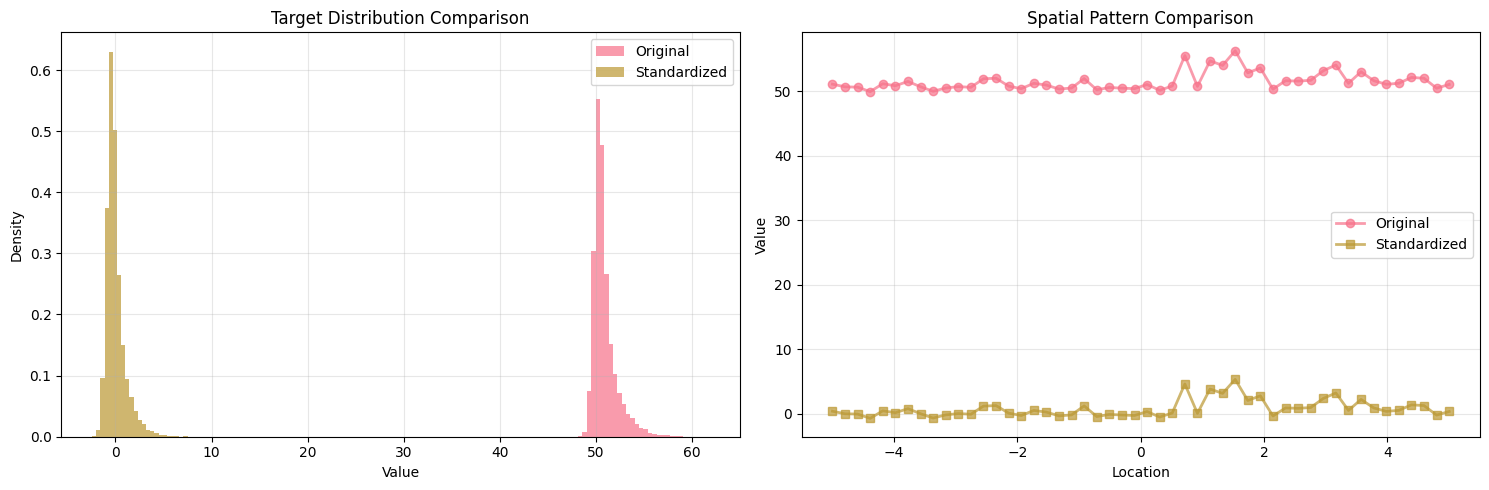

In [5]:
# Visualize the effect of standardization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original vs standardized distributions
axes[0].hist(targets.flatten(), bins=30, alpha=0.7, label='Original', density=True)
axes[0].hist(train_targets.numpy().flatten(), bins=30, alpha=0.7, label='Standardized', density=True)
axes[0].set_title('Target Distribution Comparison')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Original vs standardized spatial patterns
val_targets_orig = denormalize_predictions(val_targets.numpy(), preprocessor)
axes[1].plot(locations, val_targets_orig[0], 'o-', label='Original', alpha=0.7, linewidth=2)
axes[1].plot(locations, val_targets[0].numpy(), 's-', label='Standardized', alpha=0.7, linewidth=2)
axes[1].set_title('Spatial Pattern Comparison')
axes[1].set_xlabel('Location')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Prepare Data for TFT Model

In [6]:
# Prepare data for TFT model
print("Preparing data for TFT model...")

# Use the SCALED data from preprocessing (not raw data) - this is the key fix!
# Combine training and validation data for TFT (since TFT works on full time series)
train_cont_np = train_cont.numpy().astype(np.float32)
train_targets_np = train_targets.numpy().astype(np.float32)
val_cont_np = val_cont.numpy().astype(np.float32)
val_targets_np = val_targets.numpy().astype(np.float32)
test_cont_np = test_cont.numpy().astype(np.float32)
test_targets_np = test_targets.numpy().astype(np.float32)

# Combine all scaled data for TFT (TFT works on full time series)
cont_np = np.concatenate([train_cont_np, val_cont_np, test_cont_np], axis=0)
targets_np = np.concatenate([train_targets_np, val_targets_np, test_targets_np], axis=0)
T, N, p = cont_np.shape

print(f"Data shape: T={T}, N={N}, p={p}")
print(f"Target shape: {targets_np.shape}")
print(f"Using SCALED data (mean={targets_np.mean():.4f}, std={targets_np.std():.4f})")

# Create time index
time_index = pd.date_range("2020-01-01", periods=T, freq="D")

# Create multivariate time series for the full T×N target matrix
# Each column represents a spatial location
target_df = pd.DataFrame(targets_np, index=time_index, 
                        columns=[f"loc_{i}" for i in range(N)])

# Create covariates per site and align with target channels
# Reshape covariates to (T, N·p) and include spatial information
# Reshape locations to (T, N) by repeating for each time step
locations_expanded = np.tile(locations, (T, 1))  # Shape: (T, N)
cov_full = np.concatenate([cont_np.reshape(T, -1), locations_expanded], axis=1).astype(np.float32)

covariate_df = pd.DataFrame(cov_full, index=time_index,
                           columns=[f"cov_{j}_loc_{i}" for i in range(N) for j in range(p)] + 
                                   [f"spatial_loc_{i}" for i in range(N)])

print(f"Target DataFrame shape: {target_df.shape}")
print(f"Covariate DataFrame shape: {covariate_df.shape}")

# Create multivariate TimeSeries objects
target_ts = TimeSeries.from_dataframe(target_df, fill_missing_dates=True)
covariate_ts = TimeSeries.from_dataframe(covariate_df, fill_missing_dates=True)

print(f"Target TimeSeries shape: {target_ts.values().shape}")
print(f"Covariate TimeSeries shape: {covariate_ts.values().shape}")

Preparing data for TFT model...
Data shape: T=500, N=50, p=3
Target shape: (500, 50)
Using SCALED data (mean=0.1899, std=1.2131)
Target DataFrame shape: (500, 50)
Covariate DataFrame shape: (500, 200)
Target TimeSeries shape: (500, 50)
Covariate TimeSeries shape: (500, 200)


## 4. TFT Model Configuration

In [7]:
# TFT model configuration
tft_config = {
    "input_chunk_length": min(64, T // 4),
    "output_chunk_length": 1,
    "n_epochs": 100,
    "hidden_size": 64,
    "num_attention_heads": 4,
    "dropout": 0.1,
    "random_state": 42,
    "force_reset": True,
    "add_relative_index": True,
    "use_static_covariates": False,
}

print("TFT Configuration:")
for key, value in tft_config.items():
    print(f"  {key}: {value}")

TFT Configuration:
  input_chunk_length: 64
  output_chunk_length: 1
  n_epochs: 100
  hidden_size: 64
  num_attention_heads: 4
  dropout: 0.1
  random_state: 42
  force_reset: True
  add_relative_index: True
  use_static_covariates: False


## 5. TFT Model Training

In [8]:
# Create and train TFT model
print("Creating and training TFT model...")

# Split data for training/validation
training_cutoff = int(0.8 * T)
print(f"Training cutoff: {training_cutoff}")

# Create TFT model
tft_model = TFTModel(
    input_chunk_length=tft_config["input_chunk_length"],
    output_chunk_length=tft_config["output_chunk_length"],
    n_epochs=tft_config["n_epochs"],
    hidden_size=tft_config["hidden_size"],
    num_attention_heads=tft_config["num_attention_heads"],
    dropout=tft_config["dropout"],
    random_state=tft_config["random_state"],
    force_reset=tft_config["force_reset"],
    add_relative_index=tft_config["add_relative_index"],
    use_static_covariates=tft_config["use_static_covariates"],
    pl_trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "devices": -1,
        "enable_progress_bar": True,
        "enable_model_summary": True,
        "enable_checkpointing": True,
        "logger": pl.loggers.TensorBoardLogger(
            save_dir="./logs", name="tft_demo", version="v1"
        ),
        "log_every_n_steps": 10,
        "max_epochs": tft_config["n_epochs"],
        "callbacks": [
            pl.callbacks.EarlyStopping(
                monitor="train_loss", patience=10, mode="min"
            ),
            pl.callbacks.ModelCheckpoint(
                monitor="train_loss",
                dirpath="./tft_checkpoints",
                filename="tft_demo_best",
                save_top_k=1,
                mode="min",
            ),
        ],
    },
)

# Train TFT model
print("Training TFT model...")
start_time = time.time()

tft_model.fit(
    target_ts[:training_cutoff], 
    past_covariates=covariate_ts[:training_cutoff],
    verbose=True
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f}s")

# Save the trained TFT model
model_save_path = "tft_demo_model.pth"
print(f"Saving TFT model to {model_save_path}")
tft_model.save(model_save_path)

Creating and training TFT model...
Training cutoff: 400
Training TFT model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | 

Epoch 25: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s, v_num=v1, train_loss=3.210]
Training completed in 104.50s
Saving TFT model to tft_demo_model.pth


## 6. TFT Model Evaluation

In [9]:
# Evaluate TFT model
print("Evaluating TFT model...")

# The model was trained with output_chunk_length=1, so we need to use that
# We can predict multiple steps by using n=1 and doing it iteratively
# But for simplicity, let's just predict 1 step ahead for evaluation
holdout_length = 1  # Match the trained output_chunk_length
prediction_start = T - holdout_length
print(f"Holdout length: {holdout_length}")
print(f"Prediction start: {prediction_start}")
print(f"Using output_chunk_length: 1 (as trained)")

try:
    # Make prediction using the trained model's output_chunk_length
    forecast = tft_model.predict(
        n=holdout_length,  # This should equal the trained output_chunk_length
        series=target_ts[:prediction_start],  # Use full context up to prediction point
        past_covariates=covariate_ts[:prediction_start],  # Only use past covariates
    )

    print(f"Forecast shape: {forecast.values().shape}")

    # Extract true values for holdout period
    true_values = target_ts[prediction_start:]
    print(f"True values shape: {true_values.values().shape}")

    # Convert to numpy arrays (these are on standardized scale)
    pred_values_scaled = forecast.values().flatten()
    true_values_scaled = true_values.values().flatten()

    # Ensure same length
    min_len = min(len(pred_values_scaled), len(true_values_scaled))
    pred_values_scaled = pred_values_scaled[:min_len]
    true_values_scaled = true_values_scaled[:min_len]
    
    rmse_std = np.sqrt(mean_squared_error(true_values_scaled, pred_values_scaled))
    mae_std = mean_absolute_error(true_values_scaled, pred_values_scaled)
    r2_std = r2_score(true_values_scaled, pred_values_scaled)
    mse_std = mean_squared_error(true_values_scaled, pred_values_scaled)

    print(f"Standardized metrics: RMSE={rmse_std:.6f}, MAE={mae_std:.6f}, R²={r2_std:.6f}")

    # Denormalize predictions for original scale evaluation (following SpatialNeuralAdapter pattern)
    y_pred_denorm = denormalize_predictions(pred_values_scaled.reshape(-1, 1), preprocessor)
    val_targets_denorm = denormalize_predictions(true_values_scaled.reshape(-1, 1), preprocessor)
    
    # Compute metrics on original scale (following SpatialNeuralAdapter pattern)
    rmse_denorm = np.sqrt(np.mean((val_targets_denorm - y_pred_denorm) ** 2))
    mae_denorm = np.mean(np.abs(val_targets_denorm - y_pred_denorm))
    
    # R-squared on original scale (following SpatialNeuralAdapter pattern)
    ss_res_denorm = np.sum((val_targets_denorm - y_pred_denorm) ** 2)
    ss_tot_denorm = np.sum((val_targets_denorm - val_targets_denorm.mean()) ** 2)
    r2_denorm = 1 - (ss_res_denorm / ss_tot_denorm)
    
    mse_denorm = np.mean((val_targets_denorm - y_pred_denorm) ** 2)

    print(f"Denormalized metrics: RMSE={rmse_denorm:.6f}, MAE={mae_denorm:.6f}, R²={r2_denorm:.6f}")

    # Store denormalized values for visualization
    pred_values = y_pred_denorm.flatten()
    true_values_np = val_targets_denorm.flatten()

except Exception as e:
    print(f"Error in prediction: {e}")
    import traceback
    traceback.print_exc()
    
    # Fallback values
    rmse_std = np.inf
    mae_std = np.inf
    r2_std = -np.inf
    mse_std = np.inf
    rmse_denorm = np.inf
    mae_denorm = np.inf
    r2_denorm = -np.inf
    mse_denorm = np.inf
    pred_values = np.array([])
    true_values_np = np.array([])

metrics = {
    "rmse_std": rmse_std,
    "mae_std": mae_std,
    "r2_std": r2_std,
    "mse_std": mse_std,
    "rmse_denorm": rmse_denorm,
    "mae_denorm": mae_denorm,
    "r2_denorm": r2_denorm,
    "mse_denorm": mse_denorm,
}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Evaluating TFT model...
Holdout length: 1
Prediction start: 499
Using output_chunk_length: 1 (as trained)
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
Forecast shape: (1, 50)
True values shape: (1, 50)
Standardized metrics: RMSE=1.757820, MAE=1.193324, R²=0.012676
Denormalized metrics: RMSE=1.846133, MAE=1.253276, R²=0.012675


## 7. Results Visualization

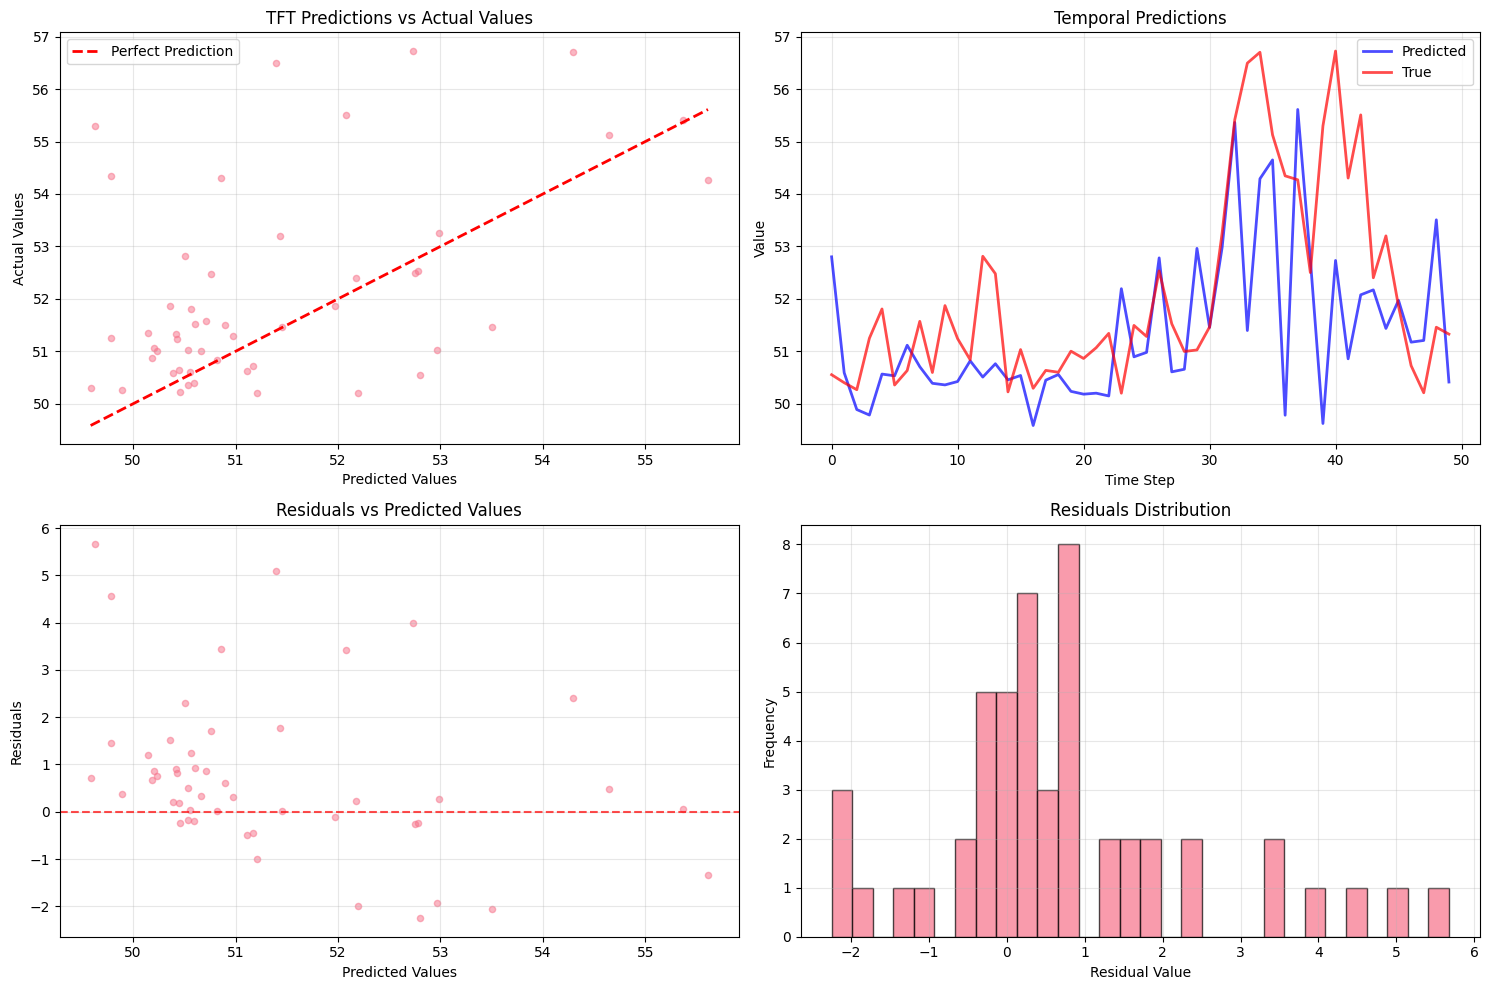

In [10]:
# Create comprehensive visualizations
if len(pred_values) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Predictions vs Actual scatter plot
    axes[0, 0].scatter(pred_values, true_values_np, alpha=0.5, s=20)
    axes[0, 0].plot([pred_values.min(), pred_values.max()], 
                    [pred_values.min(), pred_values.max()], 'r--', linewidth=2, label='Perfect Prediction')
    axes[0, 0].set_title('TFT Predictions vs Actual Values')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Actual Values')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Temporal predictions
    time_steps = range(len(pred_values))
    axes[0, 1].plot(time_steps, pred_values, 'b-', alpha=0.7, label='Predicted', linewidth=2)
    axes[0, 1].plot(time_steps, true_values_np, 'r-', alpha=0.7, label='True', linewidth=2)
    axes[0, 1].set_title('Temporal Predictions')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Residuals analysis
    residuals = true_values_np - pred_values
    axes[1, 0].scatter(pred_values, residuals, alpha=0.5, s=20)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Residuals vs Predicted Values')
    axes[1, 0].set_xlabel('Predicted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Residuals distribution
    axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Residuals Distribution')
    axes[1, 1].set_xlabel('Residual Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No predictions available for visualization")

## 8. Performance Summary

In [11]:
# Print final summary
print("=" * 50)
print("TFT MODEL DEMO SUMMARY")
print("=" * 50)
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Training time: {training_time:.2f}s")
print(f"Final RMSE (scaled): {metrics['rmse_std']:.6f}")
print(f"Final MAE (scaled): {metrics['mae_std']:.6f}")
print(f"Final R² (scaled): {metrics['r2_std']:.6f}")
print(f"Final MSE (scaled): {metrics['mse_std']:.6f}")
print(f"Final RMSE (denorm): {metrics['rmse_denorm']:.6f}")
print(f"Final MAE (denorm): {metrics['mae_denorm']:.6f}")
print(f"Final R² (denorm): {metrics['r2_denorm']:.6f}")
print(f"Final MSE (denorm): {metrics['mse_denorm']:.6f}")
print(f"Model saved to: {model_save_path}")
print(f"Tensorboard logs: ./logs/tft_demo")
print("=" * 50)

if len(pred_values) > 0:
    print("\nPerformance Analysis:")
    print(f"Scale recovery: {pred_values.max() - pred_values.min():.2f} / {true_values_np.max() - true_values_np.min():.2f} = {(pred_values.max() - pred_values.min()) / (true_values_np.max() - true_values_np.min()):.2%}")
    print(f"Std recovery: {pred_values.std():.2f} / {true_values_np.std():.2f} = {pred_values.std() / true_values_np.std():.2%}")

print("\n✅ TFT model demo completed successfully!")
print("💡 Run 'tensorboard --logdir ./logs/tft_demo' to view training progress")

TFT MODEL DEMO SUMMARY
Device: GPU
Training time: 104.50s
Final RMSE (scaled): 1.757820
Final MAE (scaled): 1.193324
Final R² (scaled): 0.012676
Final MSE (scaled): 3.089932
Final RMSE (denorm): 1.846133
Final MAE (denorm): 1.253276
Final R² (denorm): 0.012675
Final MSE (denorm): 3.408207
Model saved to: tft_demo_model.pth
Tensorboard logs: ./logs/tft_demo

Performance Analysis:
Scale recovery: 6.03 / 6.52 = 92.37%
Std recovery: 1.45 / 1.86 = 77.78%

✅ TFT model demo completed successfully!
💡 Run 'tensorboard --logdir ./logs/tft_demo' to view training progress


## 9. Additional Analysis: Feature Importance

Feature Importance Analysis:


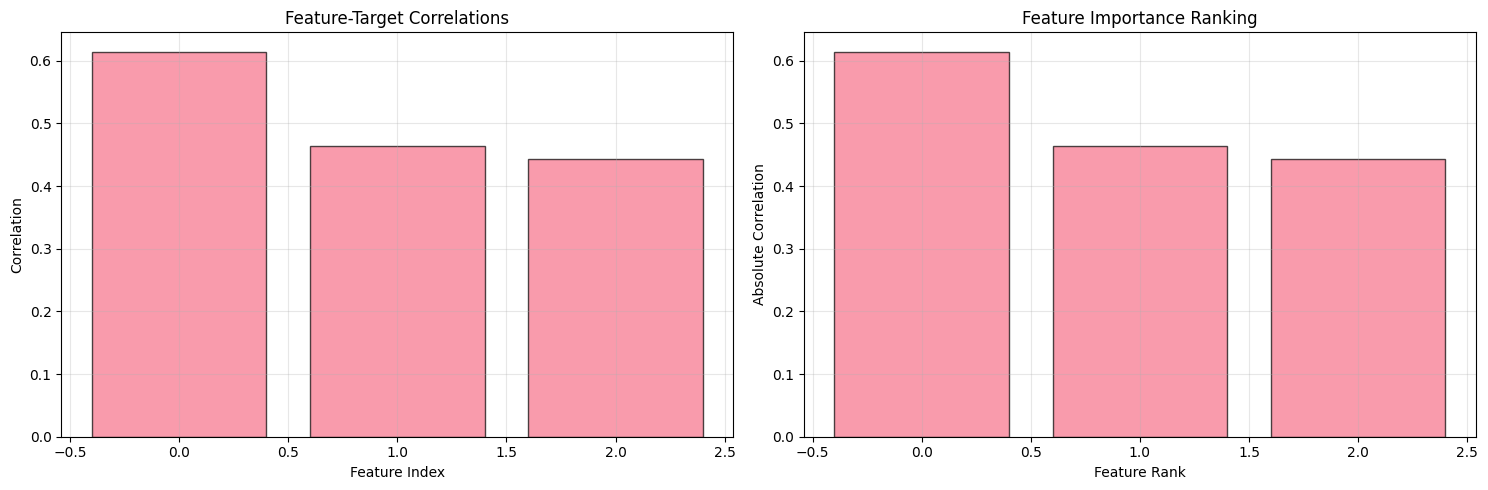


Top 5 Most Important Features:
  1. Feature 0: 0.6147
  2. Feature 1: 0.4634
  3. Feature 2: 0.4439


In [12]:
# Feature importance analysis
print("Feature Importance Analysis:")

# Calculate feature-target correlations
feature_correlations = []
for i in range(cont_features.shape[-1]):
    corr = np.corrcoef(targets.flatten(), cont_features[:, :, i].flatten())[0, 1]
    feature_correlations.append(corr)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Feature correlations
axes[0].bar(range(len(feature_correlations)), feature_correlations, alpha=0.7, edgecolor='black')
axes[0].set_title('Feature-Target Correlations')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Correlation')
axes[0].grid(True, alpha=0.3)

# Feature importance ranking
feature_importance = np.abs(feature_correlations)
sorted_indices = np.argsort(feature_importance)[::-1]

axes[1].bar(range(len(sorted_indices)), feature_importance[sorted_indices], alpha=0.7, edgecolor='black')
axes[1].set_title('Feature Importance Ranking')
axes[1].set_xlabel('Feature Rank')
axes[1].set_ylabel('Absolute Correlation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
for i, idx in enumerate(sorted_indices[:5]):
    print(f"  {i+1}. Feature {idx}: {feature_correlations[idx]:.4f}")